In [ ]:
import sys
!conda install --yes --prefix {sys.prefix} pulp



In [ ]:
import sys
!{sys.executable} -m pip install pulp


In [2563]:
import sys
sys.path.append('..')


import json
import warnings
from tqdm import tqdm
import numpy as np
import operator
import networkx as nx


warnings.filterwarnings('ignore')

#NLP
import re
import nltk
import fasttext
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer


#Visualization
import matplotlib.pyplot as plt
from MulticoreTSNE import MulticoreTSNE as TSNE
import plotly.graph_objs as go
import plotly.plotly as py
import jenkspy


#Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error

from utilities.helpers import *

In [1708]:
recipes = pd.read_json('../data/recipes_clean.json')

In [1709]:
ingredients = set([ingredient['id'] for ingredients in recipes['ingredients'] for ingredient in ingredients])

In [2409]:
%%time
ingredients_dict={}
for id in recipes.index:
    for ingredient in recipes.at[id, 'ingredients']:
        ingredients_dict.update({int(ingredient['id']):ingredient['text']})


CPU times: user 688 ms, sys: 60 ms, total: 748 ms
Wall time: 745 ms


In [2255]:
ingredients_dict_bad[2779]

'1 (15.5 ounce) can Mexican-seasoned black beans'

## Food2Vec

In [ ]:
with open ('data.txt', 'w') as f:
    for i, ingredients in tqdm(enumerate(recipes['ingredients'])):
        ids = [ingredient['id'] for ingredient in ingredients]
        f.write(' '.join(i for i in ids))
        f.write('\n')
        

In [ ]:
classifier = fasttext.fasttext

In [2555]:
model = fasttext.cbow('data.txt', 'model', dim=50, min_count = 5, epoch=100, lr=0.05)
classifier = fasttext.supervised('data.txt', 'model', label_prefix='__label__recipe')


In [2556]:
len(model.words),model.min_count

(2407, 5)

In [2557]:
corpus = sorted(model.words)
corpus.remove('</s>')
ingredients_pruned = corpus
emb_tuple = tuple([model[v] for v in corpus])
X = np.vstack(emb_tuple)

In [2558]:
#np.save('emb_tuple', emb_tuple)
#np.save('corpus', corpus)

We use TSNE for dimension reduction in order to better visualize our ingredient vectors. 

In [2580]:
%%time

tsne = TSNE(n_components=2, n_jobs=-1, n_iter=6000,perplexity=30, learning_rate=200, angle=0.2)
X_tsne = tsne.fit_transform(X)


CPU times: user 21min 28s, sys: 28min 30s, total: 49min 59s
Wall time: 1min 10s


In [2423]:
np.savetxt('ingredients.tsv', X, delimiter='\t')
#np.savetxt("ingredients.tsv", X_tsne, delimiter="\t")

names = [(ingredients_dict[int(ing)], ing) for ing in corpus]

from __future__ import print_function
with open("metadata.tsv", "w") as f:
    print('%s\t%s' % ('name', 'color'), file=f)
    for i in range(len(names)):
        print ("%s\t%s" % (names[i],color[i]), file=f)


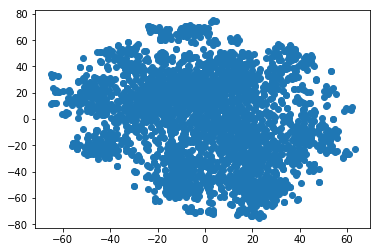

In [2581]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])


## Regression 

In [389]:
train_data_pruned = recipes.loc[recipes_pruned]

In [2162]:
train_data_pruned['saturatedFat'].loc[100008]['unit']

'g'

In [391]:
train_data_pruned.columns

Index(['calcium', 'calories', 'caloriesFromFat', 'carbohydrates',
       'cholesterol', 'fat', 'fiber', 'folate', 'health_score', 'ingredients',
       'instructions', 'iron', 'magnesium', 'niacin', 'potassium', 'protein',
       'saturatedFat', 'sodium', 'sugars', 'thiamin', 'total_time', 'vitaminA',
       'vitaminB6', 'vitaminC'],
      dtype='object')

In [692]:
sugars = train_data_pruned['sugars'].apply(lambda x: x['amount'])
fats = train_data_pruned['fat'].apply(lambda x: x['amount'])
cholesterol = train_data_pruned['cholesterol'].apply(lambda x: x['amount']/1000)
fiber = train_data_pruned['fiber'].apply(lambda x: x['amount'])
sodium = train_data_pruned['sodium'].apply(lambda x: x['amount']/1000)
protein = train_data_pruned['protein'].apply(lambda x: x['amount'])

## Ingredients health scores

In [1135]:
from sklearn.preprocessing import MinMaxScaler

In [1166]:
scaler = MinMaxScaler()

In [2158]:
recipes.columns

Index(['calcium', 'calories', 'caloriesFromFat', 'carbohydrates',
       'cholesterol', 'fat', 'fiber', 'folate', 'health_score', 'ingredients',
       'instructions', 'iron', 'magnesium', 'niacin', 'potassium', 'protein',
       'saturatedFat', 'sodium', 'sugars', 'thiamin', 'total_time', 'vitaminA',
       'vitaminB6', 'vitaminC'],
      dtype='object')

In [2203]:
nutrients =  ['sugars', 'fat', 'saturatedFat', 'sodium', 'cholesterol', 'calories', 'caloriesFromFat', 'fiber', 'protein', 'folate', 'iron', 'magnesium', 'niacin', 'potassium', 'thiamin', 'vitaminA',
       'vitaminB6', 'vitaminC']
nutrients_negative = ['sugars', 'fat', 'saturatedFat', 'sodium', 'cholesterol', 'calories', 'caloriesFromFat']
nutrients_positive = ['fiber', 'protein', 'folate', 'iron', 'magnesium', 'niacin', 'potassium', 'thiamin', 'vitaminA',
       'vitaminB6', 'vitaminC']

In [2184]:
def split(quantity_map = quantity_map_normalized_pruned, output = 'sugars'):
    if train_data_pruned[output].loc[100008]['unit'] == 'mg':
        return train_test_split(
        quantity_map, train_data_pruned[output].apply(lambda x: x['amount']/1000), test_size=0.25, random_state=42)
    elif train_data_pruned[output].loc[100008]['unit'] in ['mcg', 'IU']:
        return train_test_split(
        quantity_map, train_data_pruned[output].apply(lambda x: x['amount']/1e6), test_size=0.25, random_state=42)
    else:
        return train_test_split(
        quantity_map, train_data_pruned[output].apply(lambda x: x['amount']), test_size=0.25, random_state=42)

In [2185]:
#enet = ElasticNet(alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=10000, tol=1e-5, random_state=1, warm_start=True)
sgd = SGDRegressor(verbose=3, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=1e-5, random_state=1)

In [2186]:
nutrients

['sugars',
 'fat',
 'saturatedFat',
 'sodium',
 'cholesterol',
 'calories',
 'caloriesFromFat',
 'fiber',
 'protein',
 'folate',
 'iron',
 'magnesium',
 'niacin',
 'potassium',
 'thiamin',
 'vitaminA',
 'vitaminB6',
 'vitaminC']

In [2187]:
score_dicts={}
for nutrient in tqdm(nutrients):
    score_dicts[nutrient]={}
    X_train, X_test, y_train, y_test = split(output=nutrient)
    sgd.fit(X_train,y_train)
    for i,ing in tqdm(enumerate(ingredients_pruned)):
        score_dicts[nutrient].update({ing:(sgd.coef_[i], ingredients_dict[int(ing)])})



  0%|          | 0/18 [00:00<?, ?it/s]

-- Epoch 1
Norm: 19.68, NNZs: 2406, Bias: 11.397862, T: 31343, Avg. loss: 108.321505
Total training time: 0.21 seconds.
-- Epoch 2
Norm: 29.82, NNZs: 2406, Bias: 10.529782, T: 62686, Avg. loss: 100.749692
Total training time: 0.45 seconds.
-- Epoch 3


Norm: 37.41, NNZs: 2406, Bias: 10.930423, T: 94029, Avg. loss: 96.759803
Total training time: 0.70 seconds.
-- Epoch 4
Norm: 43.49, NNZs: 2406, Bias: 10.969662, T: 125372, Avg. loss: 94.062715
Total training time: 0.93 seconds.
-- Epoch 5
Norm: 48.57, NNZs: 2406, Bias: 10.428658, T: 156715, Avg. loss: 92.050277
Total training time: 1.20 seconds.
-- Epoch 6
Norm: 52.96, NNZs: 2406, Bias: 10.298411, T: 188058, Avg. loss: 90.488952
Total training time: 1.42 seconds.
-- Epoch 7
Norm: 56.82, NNZs: 2406, Bias: 10.125481, T: 219401, Avg. loss: 89.214695
Total training time: 1.65 seconds.
-- Epoch 8
Norm: 60.27, NNZs: 2406, Bias: 10.179445, T: 250744, Avg. loss: 88.147693
Total training time: 1.88 seconds.
-- Epoch 9
Norm: 63.37, NNZs: 2406, Bias: 10.161276, T: 282087, Avg. loss: 87.268282
Total training time: 2.09 seconds.
-- Epoch 10
Norm: 66.20, NNZs: 2406, Bias: 10.303181, T: 313430, Avg. loss: 86.490510
Total training time: 2.33 seconds.
-- Epoch 11
Norm: 68.78, NNZs: 2406, Bias: 9.907692


0it [00:00, ?it/s]
  6%|▌         | 1/18 [01:14<20:58, 74.05s/it]

Norm: 188.95, NNZs: 2406, Bias: 10.076231, T: 10249161, Avg. loss: 70.398427
Total training time: 72.81 seconds.
Convergence after 327 epochs took 72.81 seconds
-- Epoch 1
Norm: 11.97, NNZs: 2406, Bias: 16.478058, T: 31343, Avg. loss: 98.943613
Total training time: 0.20 seconds.
-- Epoch 2
Norm: 18.75, NNZs: 2406, Bias: 16.214373, T: 62686, Avg. loss: 95.212362
Total training time: 0.46 seconds.
-- Epoch 3
Norm: 23.92, NNZs: 2406, Bias: 16.174673, T: 94029, Avg. loss: 93.429462
Total training time: 0.69 seconds.
-- Epoch 4
Norm: 28.17, NNZs: 2406, Bias: 16.757342, T: 125372, Avg. loss: 92.107566
Total training time: 0.97 seconds.
-- Epoch 5
Norm: 31.89, NNZs: 2406, Bias: 16.369293, T: 156715, Avg. loss: 91.099101
Total training time: 1.23 seconds.
-- Epoch 6
Norm: 35.18, NNZs: 2406, Bias: 16.312051, T: 188058, Avg. loss: 90.238105
Total training time: 1.51 seconds.
-- Epoch 7
Norm: 38.17, NNZs: 2406, Bias: 16.491537, T: 219401, Avg. loss: 89.497579
Total training time: 1.73 seconds.
--


0it [00:00, ?it/s]
 11%|█         | 2/18 [01:50<14:41, 55.11s/it]

Norm: 142.40, NNZs: 2406, Bias: 15.820197, T: 5140252, Avg. loss: 75.682643
Total training time: 35.13 seconds.
Convergence after 164 epochs took 35.13 seconds
-- Epoch 1
Norm: 6.34, NNZs: 2406, Bias: 6.405422, T: 31343, Avg. loss: 19.558439
Total training time: 0.20 seconds.
-- Epoch 2
Norm: 10.06, NNZs: 2406, Bias: 6.102711, T: 62686, Avg. loss: 18.594269
Total training time: 0.41 seconds.
-- Epoch 3
Norm: 12.97, NNZs: 2406, Bias: 6.085759, T: 94029, Avg. loss: 18.045961
Total training time: 0.61 seconds.
-- Epoch 4
Norm: 15.41, NNZs: 2406, Bias: 6.226858, T: 125372, Avg. loss: 17.631302
Total training time: 0.82 seconds.
-- Epoch 5
Norm: 17.54, NNZs: 2406, Bias: 6.017595, T: 156715, Avg. loss: 17.307622
Total training time: 1.02 seconds.
-- Epoch 6
Norm: 19.43, NNZs: 2406, Bias: 6.079725, T: 188058, Avg. loss: 17.035263
Total training time: 1.22 seconds.
-- Epoch 7
Norm: 21.15, NNZs: 2406, Bias: 6.081131, T: 219401, Avg. loss: 16.804457
Total training time: 1.42 seconds.
-- Epoch 8



0it [00:00, ?it/s]
 17%|█▋        | 3/18 [03:09<15:46, 63.11s/it]

Norm: 85.65, NNZs: 2406, Bias: 5.533818, T: 11534224, Avg. loss: 12.925976
Total training time: 78.06 seconds.
Convergence after 368 epochs took 78.06 seconds
-- Epoch 1
Norm: 0.66, NNZs: 2406, Bias: 0.563090, T: 31343, Avg. loss: 1.113958
Total training time: 0.20 seconds.
-- Epoch 2
Norm: 1.00, NNZs: 2406, Bias: 0.579713, T: 62686, Avg. loss: 1.104284
Total training time: 0.41 seconds.
-- Epoch 3
Norm: 1.26, NNZs: 2406, Bias: 0.606794, T: 94029, Avg. loss: 1.099606
Total training time: 0.61 seconds.
-- Epoch 4
Norm: 1.48, NNZs: 2406, Bias: 0.603959, T: 125372, Avg. loss: 1.096014
Total training time: 0.82 seconds.
-- Epoch 5
Norm: 1.67, NNZs: 2406, Bias: 0.603378, T: 156715, Avg. loss: 1.093365
Total training time: 1.02 seconds.
-- Epoch 6
Norm: 1.85, NNZs: 2406, Bias: 0.607838, T: 188058, Avg. loss: 1.090802
Total training time: 1.23 seconds.
-- Epoch 7
Norm: 2.01, NNZs: 2406, Bias: 0.596765, T: 219401, Avg. loss: 1.088689
Total training time: 1.43 seconds.
-- Epoch 8
Norm: 2.15, NN


0it [00:00, ?it/s]

Norm: 13.25, NNZs: 2406, Bias: 0.704223, T: 7553663, Avg. loss: 0.994238
Total training time: 48.90 seconds.
-- Epoch 242
Norm: 13.28, NNZs: 2406, Bias: 0.679297, T: 7585006, Avg. loss: 0.994252
Total training time: 49.09 seconds.
Convergence after 242 epochs took 49.09 seconds



 22%|██▏       | 4/18 [03:59<13:58, 59.87s/it]

-- Epoch 1
Norm: 0.06, NNZs: 2406, Bias: 0.058179, T: 31343, Avg. loss: 0.002434
Total training time: 0.20 seconds.
-- Epoch 2
Norm: 0.09, NNZs: 2406, Bias: 0.058254, T: 62686, Avg. loss: 0.002359
Total training time: 0.39 seconds.
-- Epoch 3
Norm: 0.11, NNZs: 2406, Bias: 0.057434, T: 94029, Avg. loss: 0.002316
Total training time: 0.59 seconds.
-- Epoch 4
Norm: 0.14, NNZs: 2406, Bias: 0.058185, T: 125372, Avg. loss: 0.002283
Total training time: 0.78 seconds.
-- Epoch 5
Norm: 0.15, NNZs: 2406, Bias: 0.056676, T: 156715, Avg. loss: 0.002257
Total training time: 0.98 seconds.
-- Epoch 6
Norm: 0.17, NNZs: 2406, Bias: 0.057001, T: 188058, Avg. loss: 0.002235
Total training time: 1.17 seconds.
-- Epoch 7
Norm: 0.19, NNZs: 2406, Bias: 0.056923, T: 219401, Avg. loss: 0.002216
Total training time: 1.37 seconds.
-- Epoch 8
Norm: 0.20, NNZs: 2406, Bias: 0.058955, T: 250744, Avg. loss: 0.002199
Total training time: 1.56 seconds.
-- Epoch 9
Norm: 0.22, NNZs: 2406, Bias: 0.057230, T: 282087, Avg. 


0it [00:00, ?it/s]


Norm: 0.26, NNZs: 2406, Bias: 0.057299, T: 407459, Avg. loss: 0.002136
Total training time: 2.57 seconds.
-- Epoch 14
Norm: 0.27, NNZs: 2406, Bias: 0.056800, T: 438802, Avg. loss: 0.002126
Total training time: 2.76 seconds.
Convergence after 14 epochs took 2.76 seconds


 28%|██▊       | 5/18 [04:03<10:32, 48.66s/it]

-- Epoch 1
Norm: 130.66, NNZs: 2406, Bias: 321.750247, T: 31343, Avg. loss: 23050.889913
Total training time: 0.19 seconds.
-- Epoch 2
Norm: 208.09, NNZs: 2406, Bias: 316.757200, T: 62686, Avg. loss: 22414.986582
Total training time: 0.39 seconds.
-- Epoch 3
Norm: 268.06, NNZs: 2406, Bias: 318.519280, T: 94029, Avg. loss: 22175.033143
Total training time: 0.59 seconds.
-- Epoch 4
Norm: 318.25, NNZs: 2406, Bias: 327.973781, T: 125372, Avg. loss: 21995.175492
Total training time: 0.79 seconds.
-- Epoch 5
Norm: 362.63, NNZs: 2406, Bias: 320.447277, T: 156715, Avg. loss: 21853.097156
Total training time: 0.99 seconds.
-- Epoch 6
Norm: 402.46, NNZs: 2406, Bias: 321.335955, T: 188058, Avg. loss: 21731.346853
Total training time: 1.19 seconds.
-- Epoch 7
Norm: 438.91, NNZs: 2406, Bias: 323.142473, T: 219401, Avg. loss: 21623.031267
Total training time: 1.38 seconds.
-- Epoch 8
Norm: 472.55, NNZs: 2406, Bias: 327.356396, T: 250744, Avg. loss: 21529.828961
Total training time: 1.58 seconds.
-- 


0it [00:00, ?it/s]
 33%|███▎      | 6/18 [04:37<09:15, 46.31s/it]

Norm: 1906.83, NNZs: 2406, Bias: 326.350971, T: 5140252, Avg. loss: 19155.197728
Total training time: 33.48 seconds.
Convergence after 164 epochs took 33.48 seconds
-- Epoch 1
Norm: 107.71, NNZs: 2406, Bias: 148.298754, T: 31343, Avg. loss: 8014.974494
Total training time: 0.20 seconds.
-- Epoch 2
Norm: 168.73, NNZs: 2406, Bias: 145.923225, T: 62686, Avg. loss: 7712.796172
Total training time: 0.40 seconds.
-- Epoch 3
Norm: 215.24, NNZs: 2406, Bias: 145.559696, T: 94029, Avg. loss: 7568.392467
Total training time: 0.66 seconds.
-- Epoch 4
Norm: 253.55, NNZs: 2406, Bias: 150.807134, T: 125372, Avg. loss: 7461.317907
Total training time: 0.86 seconds.
-- Epoch 5
Norm: 286.96, NNZs: 2406, Bias: 147.228264, T: 156715, Avg. loss: 7379.621015
Total training time: 1.06 seconds.
-- Epoch 6
Norm: 316.65, NNZs: 2406, Bias: 146.793555, T: 188058, Avg. loss: 7309.909711
Total training time: 1.26 seconds.
-- Epoch 7
Norm: 343.53, NNZs: 2406, Bias: 148.410674, T: 219401, Avg. loss: 7249.894558
Total


0it [00:00, ?it/s]
 39%|███▉      | 7/18 [05:12<08:10, 44.60s/it]

Norm: 1281.47, NNZs: 2406, Bias: 142.328166, T: 5140252, Avg. loss: 6131.070435
Total training time: 33.28 seconds.
Convergence after 164 epochs took 33.28 seconds
-- Epoch 1
Norm: 2.81, NNZs: 2406, Bias: 2.757834, T: 31343, Avg. loss: 4.638527
Total training time: 0.21 seconds.
-- Epoch 2
Norm: 4.22, NNZs: 2406, Bias: 2.730785, T: 62686, Avg. loss: 4.467964
Total training time: 0.41 seconds.
-- Epoch 3
Norm: 5.25, NNZs: 2406, Bias: 2.846164, T: 94029, Avg. loss: 4.390455
Total training time: 0.61 seconds.
-- Epoch 4
Norm: 6.08, NNZs: 2406, Bias: 2.954044, T: 125372, Avg. loss: 4.335787
Total training time: 0.82 seconds.
-- Epoch 5
Norm: 6.80, NNZs: 2406, Bias: 2.906601, T: 156715, Avg. loss: 4.294797
Total training time: 1.02 seconds.
-- Epoch 6
Norm: 7.44, NNZs: 2406, Bias: 2.945099, T: 188058, Avg. loss: 4.259801
Total training time: 1.23 seconds.
-- Epoch 7
Norm: 8.02, NNZs: 2406, Bias: 2.929317, T: 219401, Avg. loss: 4.229539
Total training time: 1.43 seconds.
-- Epoch 8
Norm: 8.5


0it [00:00, ?it/s]
 44%|████▍     | 8/18 [06:27<08:03, 48.38s/it]

Norm: 43.91, NNZs: 2406, Bias: 3.028142, T: 11189451, Avg. loss: 3.305317
Total training time: 73.73 seconds.
Convergence after 357 epochs took 73.73 seconds
-- Epoch 1
Norm: 16.71, NNZs: 2406, Bias: 14.036127, T: 31343, Avg. loss: 95.283590
Total training time: 0.21 seconds.
-- Epoch 2
Norm: 25.51, NNZs: 2406, Bias: 14.329462, T: 62686, Avg. loss: 89.249987
Total training time: 0.41 seconds.
-- Epoch 3
Norm: 32.01, NNZs: 2406, Bias: 14.317837, T: 94029, Avg. loss: 86.257828
Total training time: 0.62 seconds.
-- Epoch 4
Norm: 37.26, NNZs: 2406, Bias: 14.826704, T: 125372, Avg. loss: 84.179174
Total training time: 0.83 seconds.
-- Epoch 5
Norm: 41.77, NNZs: 2406, Bias: 14.477243, T: 156715, Avg. loss: 82.574676
Total training time: 1.03 seconds.
-- Epoch 6
Norm: 45.73, NNZs: 2406, Bias: 14.704372, T: 188058, Avg. loss: 81.276291
Total training time: 1.24 seconds.
-- Epoch 7
Norm: 49.30, NNZs: 2406, Bias: 14.800262, T: 219401, Avg. loss: 80.166148
Total training time: 1.51 seconds.
-- Ep


0it [00:00, ?it/s]
 50%|█████     | 9/18 [07:22<07:22, 49.14s/it]

Norm: 198.22, NNZs: 2406, Bias: 15.771246, T: 8180523, Avg. loss: 57.822041
Total training time: 54.16 seconds.
Convergence after 261 epochs took 54.16 seconds
-- Epoch 1
Norm: 0.00, NNZs: 2406, Bias: 0.000047, T: 31343, Avg. loss: 0.000000
Total training time: 0.21 seconds.
-- Epoch 2



0it [00:00, ?it/s]
 56%|█████▌    | 10/18 [07:23<05:54, 44.37s/it]

Norm: 0.00, NNZs: 2406, Bias: 0.000048, T: 62686, Avg. loss: 0.000000
Total training time: 0.41 seconds.
Convergence after 2 epochs took 0.41 seconds
-- Epoch 1
Norm: 0.00, NNZs: 2406, Bias: 0.002212, T: 31343, Avg. loss: 0.000004
Total training time: 0.21 seconds.
-- Epoch 2



0it [00:00, ?it/s]
 61%|██████    | 11/18 [07:25<04:43, 40.47s/it]

Norm: 0.00, NNZs: 2406, Bias: 0.002265, T: 62686, Avg. loss: 0.000004
Total training time: 0.41 seconds.
Convergence after 2 epochs took 0.41 seconds
-- Epoch 1
Norm: 0.03, NNZs: 2406, Bias: 0.037399, T: 31343, Avg. loss: 0.000580
Total training time: 0.20 seconds.
-- Epoch 2
Norm: 0.05, NNZs: 2406, Bias: 0.037184, T: 62686, Avg. loss: 0.000555
Total training time: 0.41 seconds.
-- Epoch 3
Norm: 0.06, NNZs: 2406, Bias: 0.038006, T: 94029, Avg. loss: 0.000544
Total training time: 0.62 seconds.
-- Epoch 4



0it [00:00, ?it/s]
 67%|██████▋   | 12/18 [07:27<03:43, 37.26s/it]

Norm: 0.07, NNZs: 2406, Bias: 0.039850, T: 125372, Avg. loss: 0.000537
Total training time: 0.83 seconds.
Convergence after 4 epochs took 0.83 seconds
-- Epoch 1
Norm: 0.01, NNZs: 2406, Bias: 0.005624, T: 31343, Avg. loss: 0.000019
Total training time: 0.25 seconds.
-- Epoch 2



0it [00:00, ?it/s]
 72%|███████▏  | 13/18 [07:28<02:52, 34.52s/it]

Norm: 0.01, NNZs: 2406, Bias: 0.005660, T: 62686, Avg. loss: 0.000018
Total training time: 0.48 seconds.
Convergence after 2 epochs took 0.48 seconds
-- Epoch 1
Norm: 0.41, NNZs: 2406, Bias: 0.379254, T: 31343, Avg. loss: 0.060516
Total training time: 0.19 seconds.
-- Epoch 2
Norm: 0.61, NNZs: 2406, Bias: 0.375312, T: 62686, Avg. loss: 0.057062
Total training time: 0.40 seconds.
-- Epoch 3
Norm: 0.75, NNZs: 2406, Bias: 0.389353, T: 94029, Avg. loss: 0.055604
Total training time: 0.60 seconds.
-- Epoch 4
Norm: 0.86, NNZs: 2406, Bias: 0.404243, T: 125372, Avg. loss: 0.054673
Total training time: 0.89 seconds.
-- Epoch 5
Norm: 0.95, NNZs: 2406, Bias: 0.395423, T: 156715, Avg. loss: 0.053999
Total training time: 1.19 seconds.
-- Epoch 6
Norm: 1.02, NNZs: 2406, Bias: 0.401773, T: 188058, Avg. loss: 0.053468
Total training time: 1.49 seconds.
-- Epoch 7
Norm: 1.09, NNZs: 2406, Bias: 0.396494, T: 219401, Avg. loss: 0.053021
Total training time: 1.72 seconds.
-- Epoch 8
Norm: 1.15, NNZs: 2406,


0it [00:00, ?it/s]
 78%|███████▊  | 14/18 [08:06<02:18, 34.73s/it]

Norm: 3.50, NNZs: 2406, Bias: 0.396482, T: 5046223, Avg. loss: 0.044918
Total training time: 34.85 seconds.
Convergence after 161 epochs took 34.85 seconds
-- Epoch 1
Norm: 0.00, NNZs: 2406, Bias: 0.000184, T: 31343, Avg. loss: 0.000000
Total training time: 0.20 seconds.
-- Epoch 2



0it [00:00, ?it/s]
 83%|████████▎ | 15/18 [08:07<01:37, 32.51s/it]

Norm: 0.00, NNZs: 2406, Bias: 0.000184, T: 62686, Avg. loss: 0.000000
Total training time: 0.41 seconds.
Convergence after 2 epochs took 0.41 seconds
-- Epoch 1
Norm: 0.00, NNZs: 2406, Bias: 0.001460, T: 31343, Avg. loss: 0.000006
Total training time: 0.21 seconds.
-- Epoch 2



0it [00:00, ?it/s]
 89%|████████▉ | 16/18 [08:09<01:01, 30.57s/it]

Norm: 0.00, NNZs: 2406, Bias: 0.001327, T: 62686, Avg. loss: 0.000006
Total training time: 0.42 seconds.
Convergence after 2 epochs took 0.42 seconds
-- Epoch 1
Norm: 0.00, NNZs: 2406, Bias: 0.000279, T: 31343, Avg. loss: 0.000000
Total training time: 0.20 seconds.
-- Epoch 2



0it [00:00, ?it/s]
 94%|█████████▍| 17/18 [08:10<00:28, 28.86s/it]

Norm: 0.00, NNZs: 2406, Bias: 0.000277, T: 62686, Avg. loss: 0.000000
Total training time: 0.45 seconds.
Convergence after 2 epochs took 0.45 seconds
-- Epoch 1
Norm: 0.02, NNZs: 2406, Bias: 0.015215, T: 31343, Avg. loss: 0.000396
Total training time: 0.19 seconds.
-- Epoch 2
Norm: 0.03, NNZs: 2406, Bias: 0.015488, T: 62686, Avg. loss: 0.000385
Total training time: 0.39 seconds.
-- Epoch 3
Norm: 0.04, NNZs: 2406, Bias: 0.016562, T: 94029, Avg. loss: 0.000380
Total training time: 0.59 seconds.



0it [00:00, ?it/s]
100%|██████████| 18/18 [08:12<00:00, 27.35s/it]

Convergence after 3 epochs took 0.59 seconds


In [ ]:
%%time
sgd.fit(X_train, y_train)


In [697]:
predictions = sgd.predict(X_test)

In [699]:
print("MAE:", mean_absolute_error(y_test, predictions))
print("MSE:", np.sqrt(mean_squared_error(y_test, predictions)))


MAE: 7.44136084223
MSE: 11.6904129712


In [483]:
regr = RandomForestRegressor(max_depth=10, n_estimators=100, n_jobs=-1, verbose=2)

In [ ]:
%%time
regr.fit(X_train, y_train)

In [485]:
fetures = regr.feature_importances_

In [700]:
#ing2score_protein = {}
#for i,ing in tqdm(enumerate(ingredients_pruned)):
#    ing2score_protein.update({ing:(sgd.coef_[i], ingredients_dict[int(ing)])})


2406it [00:00, 240399.62it/s]


In [2188]:
nutrient_dicts = [score_dicts[item] for item in score_dicts]

In [2190]:
nutri2scores = {}
for i,dict in enumerate(nutrient_dicts):
    nutri2scores.update({nutrients[i]:[dict[item][0] for item in corpus]})

In [2191]:
for nutri in nutri2scores:
    nutri2scores.update({nutri:scaler.fit_transform(np.c_[nutri2scores[nutri]])})

In [2192]:

for i, ing in enumerate(corpus):
    ing2scores.update({ing:{nutrient:nutri2scores[nutrient][i][0] for nutrient in nutrients}})

In [1330]:
quantity_map_pruned.loc[131102].iloc[quantity_map_pruned.loc[131102].nonzero()]

1526     170.000
16278      0.002
16317     12.000
16401      1.050
16424      8.400
Name: 131102, dtype: float64

In [2215]:
ing2score = {}
for item in ing2scores:
    ing2score[item]=sum([ing2scores[item][nutrient] for nutrient in nutrients_negative if train_data_pruned[nutrient].loc[100008]['unit']=='g'])
    ing2score[item]+=sum([ing2scores[item][nutrient]/1000 for nutrient in nutrients_negative if train_data_pruned[nutrient].loc[100008]['unit']=='mg'])
    ing2score[item]+=sum([ing2scores[item][nutrient]/1e6 for nutrient in nutrients_negative if train_data_pruned[nutrient].loc[100008]['unit'] in ['mcg','IU']])

    ing2score[item]-=sum([ing2scores[item][nutrient] for nutrient in nutrients_positive if train_data_pruned[nutrient].loc[100008]['unit']=='g'])
    ing2score[item]-=sum([ing2scores[item][nutrient]/1000 for nutrient in nutrients_positive if train_data_pruned[nutrient].loc[100008]['unit']=='mg'])
    ing2score[item]-=sum([ing2scores[item][nutrient]/1e6 for nutrient in nutrients_positive if train_data_pruned[nutrient].loc[100008]['unit'] in ['mcg','IU']])


In [2322]:
x_sorted = sorted(ing2score.items(), key=operator.itemgetter(1), reverse=False)


In [2323]:
x_sorted[:10]

[('2829', -0.7549802494152319),
 ('2779', -0.70419863020148044),
 ('2795', -0.61959462306950386),
 ('2819', -0.22907960128433738),
 ('1683', -0.20553228915462446),
 ('23274', -0.15256115672480575),
 ('4664', -0.15173102640911942),
 ('10498', -0.11798820725989441),
 ('2813', -0.098829765833119282),
 ('3717', -0.097604712716295561)]

In [2326]:
for item in x_sorted[:10]:
    print(ingredients_dict[int(item[0])], item[1], item)

brown lentils -0.754980249415 ('2829', -0.7549802494152319)
asoned black beans -0.704198630201 ('2779', -0.70419863020148044)
kidney beans -0.61959462307 ('2795', -0.61959462306950386)
rbanzo beans, drained -0.229079601284 ('2819', -0.22907960128433738)
whole wheat flour -0.205532289155 ('1683', -0.20553228915462446)
vegetable broth -0.152561156725 ('23274', -0.15256115672480575)
canned crushed tomatoes -0.151731026409 ('4664', -0.15173102640911942)
 diced tomatoes -0.11798820726 ('10498', -0.11798820725989441)
 fresh fava beans, shelled -0.0988297658331 ('2813', -0.098829765833119282)
 chopped fresh cilantro -0.0976047127163 ('3717', -0.097604712716295561)


In [1349]:
for recipe in quantity_map_pruned:
    print(recipe)
    x = quantity_map_pruned.loc[recipe]
    print([ing2scores[str(ing)][nutrient]*x[str(ing)] for ing in list(x.iloc[x.nonzero()].index) for nutrient in nutrients])
    break

131102
12.0
[166.49183819228875, 23.075062007153768, 0.0, 5.5255064185619513, 0.00082392624737113161, 0.00067550902415087512, 0.00011417448136322064, 0.0011125977657388104, 1.9019421385219362, 3.9891200544275915, 0.72936532207562799, 5.7023648587242288, 0.23834420624281455, 0.36540719416548495, 0.084930406459448313, 0.31646779665736746, 1.9879688089225127, 2.9307410728732233, 0.62186208934528198, 2.544108250193335]


In [1357]:
hss = quantity_map_normalized_pruned.apply(lambda x: sum([ing2scores[str(ing)][nutrient]*x[str(ing)] for ing in list(x.iloc[x.nonzero()].index) for nutrient in nutrients]), axis=1)

In [1253]:
quantity_map_pruned.loc[10011].iloc[quantity_map_pruned.loc[10011].nonzero()]

1526     340.000000
16157    340.000000
16317      1.000000
16421      1.050000
16424      8.400000
1684     906.666667
Name: 10011, dtype: float64

In [1362]:
cat = []
jenks = jenkspy.jenks_breaks(list(hss), nb_class=3)
for i,score in enumerate(hss):
    found_class = False
    for i in range(len(jenks)-1):
        if score>=jenks[i] and score<jenks[i+1]:
            cat.append(i+1)
            found_class = True
            #print(jenks[i], jenks[i+1],ing2score[item][0]+offset,i+1 )
            break
    if found_class == False:
        cat.append(len(jenks)-1)   


In [1367]:
len([i for i in cat if i==3])

8070

In [1375]:
data = pd.Series(hss)

In [1383]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [1745]:
def print_scores(scores, n=10):
    sorted_x = sorted(scores.items(), key=operator.itemgetter(1),reverse=True)
    print(sorted_x[:10])


In [518]:
ing2score_combined={}
for item in sorted_x:
    if ing2score_sgd[item[0]][0]>0:
        ing2score_combined[item[0]] = ing2score_forrest[item[0]]
    else:
        ing2score_combined[item[0]] = (-ing2score_forrest[item[0]][0],ing2score_forrest[item[0]][1])

In [1851]:

def set_color(ing2score,nb_class=6):
    color = []
    scores = [ing2score[item][0] for item in corpus]
    offset = np.abs(min(scores))
    jenks = jenkspy.jenks_breaks(scores+offset, nb_class)
    for item in corpus:
        found_class = False
        for i in range(len(jenks)-1):
            if ing2score[item][0]+offset>=jenks[i] and ing2score[item][0]+offset<jenks[i+1]:
                color.append(i+1)
                found_class = True
                #print(jenks[i], jenks[i+1],ing2score[item][0]+offset,i+1 )
                break
        if found_class == False:
            color.append(len(jenks)-1)   
    return color

In [1833]:
G = nx.read_gpickle('G_pruned.gpickle')

In [1852]:
def set_size(G,nb_class=6):
    size = []
    scores = [np.log(len(train_data_pruned)/len(list(G.neighbors(node)))) for node in corpus]
    offset = np.abs(min(scores))
    jenks = jenkspy.jenks_breaks(scores+offset, nb_class)
    
    for j,item in enumerate(corpus):
        found_class = False
        for i in range(len(jenks)-1):
            if scores[j]+offset>=jenks[i] and scores[j]+offset<jenks[i+1]:
                size.append((i+1)*5)
                found_class = True
               
                #print(jenks[i], jenks[i+1],ing2score[item][0]+offset,i+1 )
                break
        if found_class == False:
            size.append((len(jenks)-1)*5)   
    return size 

In [2102]:
a = np.load('wass_distances.npy').item()

In [2113]:
b = np.load('wass_jaccard_distances.npy').item()

In [ ]:
sorted(a.items(), key=operator.itemgetter(1))

In [ ]:
for ing in sorted(ing2score.items(), key=operator.itemgetter(1), reverse=True):
    print(ingredients_dict[int(ing[0])])

In [ ]:
sorted(score_dicts['vitaminA'].items(), key=operator.itemgetter(1), reverse=False)

In [2586]:
scores = score_dicts['protein']
#color = [scores[item][0] for item in corpus]
#offset = np.abs(min(color))
#color = color+offset
#color = np.log(color)
labels = [(ingredients_dict[int(word)]+' '+word+' '+str(scores[word][0])) for word in corpus]
color = set_color(scores, nb_class=6)
size = set_size(G, nb_class=6)
trace1 = go.Scatter(
    x = X_tsne[:, 1],
    y = X_tsne[:, 0],
    #z = X_tsne[:, 2],
    mode='markers',
    marker=dict(
        size=[16]*len(ingredients_pruned),#size,
        color = color, #set color equal to a variable
        colorscale=[[0.0, 'rgb(165,0,38)'], [0.1111111111111111, 'rgb(215,48,39)'], [0.2222222222222222, 'rgb(244,109,67)'],
        [0.3333333333333333, 'rgb(253,174,97)'], [0.4444444444444444, 'rgb(254,224,144)'], [0.5555555555555556, 'rgb(224,243,248)'],
        [0.6666666666666666, 'rgb(171,217,233)'],[0.7777777777777778, 'rgb(116,173,209)'], [0.8888888888888888, 'rgb(69,117,180)'],
        [1.0, 'rgb(49,54,149)']],#'Viridis',
        showscale=True,
        #opacity=np.array(color)*0.2
    ),
    text=labels
)
data = [trace1]


py.iplot(data, filename='scatter-plot-with-colorscale')

In [2476]:
import gensim
def most_similar(ingredient_id, n=100):
    m = gensim.models.KeyedVectors.load_word2vec_format('model.vec')
    print(ingredients_dict[ingredient_id])
    print()
    #for id, score in m.most_similar(str(ingredient_id), topn=n):
        #if ing2freq[id]<100:
        #    continue
    return [ingredients_dict[int(id)] for id,_ in m.most_similar(str(ingredient_id), topn=n)]


In [2502]:
most_similar(16293, n=5)

4 tablespoons powdered buttermilk



['3/4 cup dry milk powder',
 '1 tablespoon instant powdered milk',
 '1 (5 ounce) can nonfat evaporated milk',
 '1 cup chocolate milk',
 '1 egg']

In [2471]:
cos_dict={}
for ing in ingredients_pruned:
    cos_dict[ing] = model.cosine_similarity('16317', ing)

In [2389]:
sorted(cos_dict.items(), key=operator.itemgetter(1), reverse=True)[:10]

[('16317', 0.99999999999999978),
 ('16293', 0.84876013197082889),
 ('16287', 0.83019833384660324),
 ('1631', 0.82595286300844195),
 ('16286', 0.82176260353269592),
 ('16291', 0.82015254115264091),
 ('16278', 0.81867366549404641),
 ('16289', 0.81703451827747664),
 ('16348', 0.80704087868375662),
 ('16347', 0.80254828607583539)]

In [825]:
quantity_map_normalized.loc[100008].iloc[quantity_map_normalized.loc[100008].nonzero()].index.tolist()

['1526', '18752', '18868', '4343']

In [845]:
ing2freq = np.load('ing2freq.npy').item()

In [849]:
ing2freq_sorted = sorted(ing2freq.items(), key=operator.itemgetter(1), reverse=True)